### Experiments with topic modeling as community detection in Gregorian chant repertoire data
First some parameter selection  

1. 2, 5, 10 and 20 topics for all data
2. evaluation via six czech sources
3. big feasts data only
4. union same provenances (with some additional restrictions) and treat them as documents

#### Common code

In [1]:
# Imports
import numpy as np
import pandas as pd

import lzma
import pickle

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

from collections import Counter, OrderedDict
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path', 'siglum', 'cursus', 'num_century'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

chants = pd.concat([responsories_all, antiphons_all])

In [3]:
# Construct dict to index sources
source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1

In [4]:
# Transform chant data into document like structure
source_all_chants_dict = {}
used_cantus_ids = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants['source_id'] == source_id
    used_cantus_ids += (chants[filt_source]['cantus_id']).tolist()
    source_all_chants_dict[source_id] = ' '.join((chants[filt_source]['cantus_id']).tolist())

print("Number of chants in our sources", len(used_cantus_ids))
freq_CIDs = Counter(used_cantus_ids)
print('Number of CIDs used in our sources', len(set(used_cantus_ids)))

Number of chants in our sources 362632
Number of CIDs used in our sources 17599


In [1]:
def count_jaccard(community_variants, used_dict):
    jaccard = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
    for pair in all_variants_pairs:
        friends_matrix = np.zeros([len(used_dict), len(used_dict)])
        for com_ver in pair:
            for com in com_ver:
                com = sorted(list(com))
                for s_pair in combinations(com, 2):
                    friends_matrix[used_dict[s_pair[0]], used_dict[s_pair[1]]] += 1
        unique, counts = np.unique(friends_matrix.flatten(), return_counts=True)
        try:
            twos = dict(zip(unique, counts))[2]
            sig_level = twos / np.count_nonzero(friends_matrix)
        except:
            sig_level = 0.0
        jaccard.append(sig_level)
    
    return (round(np.mean(jaccard), 2)) 

In [6]:
def count_rand(community_variants_labels):
    rand = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        rand.append(adjusted_rand_score(pair[0], pair[1]))
        
    return(np.mean(rand))

In [7]:
def count_mutual(community_variants_labels):
    mutual = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        mutual.append(adjusted_mutual_info_score(pair[0], pair[1]))
        
    return(np.mean(mutual))

#### Choose CountVectorizer settings

In [8]:
# Plot of how maximal required document frequency affects number of CI while min_df fixed on extreme value
max_dfs = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250]
max_df_chants_dict = {}
for i in max_dfs:
    cv = CountVectorizer(max_df=i, min_df=0.0)
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    max_df_chants_dict[i] = cv_data.shape[1]

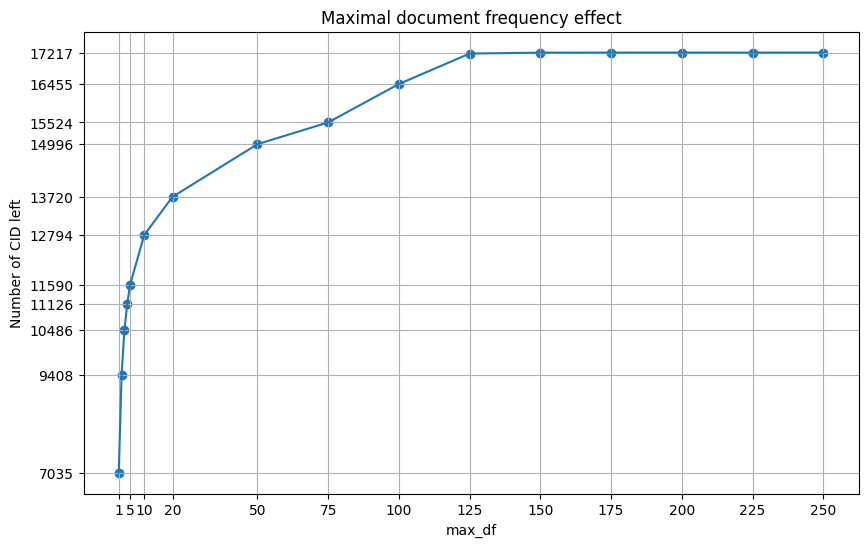

In [9]:
#plt.bar(x=max_df_chants_dict.keys(), height=max_df_chants_dict.values())
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(x=max_df_chants_dict.keys(), y=max_df_chants_dict.values())
plt.plot(max_df_chants_dict.keys(), max_df_chants_dict.values())
plt.title("Maximal document frequency effect")
plt.xticks([1, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250])
plt.yticks(list(max_df_chants_dict.values())[:-6] + [list(max_df_chants_dict.values())[-1]])
plt.xlabel("max_df")
plt.ylabel("Number of CID left")
plt.show()

In [10]:
# Plot of how minimal required document frequency affects number of CI while max_df fixed on extreme value
min_df_chants_dict = {}
for i in range(1, 21):
    cv = CountVectorizer(max_df=1.0, min_df=i)
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    min_df_chants_dict[i] = cv_data.shape[1]

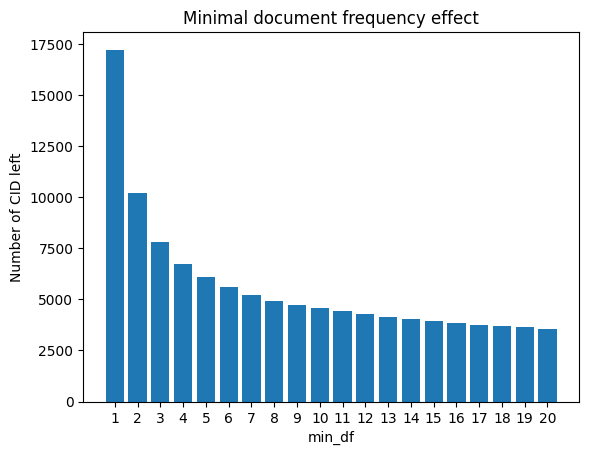

In [11]:
plt.bar(x=min_df_chants_dict.keys(), height=min_df_chants_dict.values())
plt.title("Minimal document frequency effect")
plt.xticks(list(min_df_chants_dict.keys()))
plt.xlabel("min_df")
plt.ylabel("Number of CID left")
plt.show()

##### Our three CountVectorizer possibilites

In [12]:
# Construct [sources x chants] matrix (document word matrix) for almost all data
all_count_vec = CountVectorizer(max_df=len(sources), min_df=0.0)
all_count_vec_data = all_count_vec.fit_transform(source_all_chants_dict.values())
print("Most wide [sources x chants] matrix shape:", all_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - all_count_vec_data.shape[1], "CIDs")

Most wide [sources x chants] matrix shape: (250, 17217)
Loosing 382 CIDs


In [13]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 250 or less docs and also it at least two docs
less_count_vec = CountVectorizer(max_df=250, min_df=2)
less_count_vec_data = less_count_vec.fit_transform(source_all_chants_dict.values())
print("Less wide [sources x chants] matrix shape:", less_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - less_count_vec_data.shape[1], "CIDs")

Less wide [sources x chants] matrix shape: (250, 10182)
Loosing 7417 CIDs


In [14]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 250 or less docs and also it at least eight docs
smallest_count_vec = CountVectorizer(max_df=250, min_df=8)
smallest_count_vec_data = smallest_count_vec.fit_transform(source_all_chants_dict.values())
print("The least wide [sources x chants] matrix shape:", smallest_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - smallest_count_vec_data.shape[1], "CIDs")

The least wide [sources x chants] matrix shape: (250, 4925)
Loosing 12674 CIDs


In [15]:
cv_options = [all_count_vec, less_count_vec, smallest_count_vec]
cv_opt_string = ["all_count_vec", "less_count_vec", "smallest_count_vec"]
random_states = [i for i in range(1, 50)]

### Parameters search
max_iter  
CountVectorizer

In [16]:
# Run LDA for num_of_topics topics on all data with max_iter options in num_of_runs repeat 
# and return counted three scores

def LDA_basic_run(num_of_runs, num_of_topics, max_iter_options, cv, random_states):
    iter_metric_dict = {}
    for iter in max_iter_options:
        community_variants = []
        community_variants_labels = []
        for i in range(num_of_runs):
            model = LatentDirichletAllocation(n_components=num_of_topics, max_iter=iter, evaluate_every=1, random_state=random_states[i])
            data_trans = cv.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
            result = model.fit_transform(data_trans)
            topics = result.argmax(axis=1)

            community_variants_labels.append(topics)

            restored_comm = {}
            for topic in range(num_of_topics):
                restored_comm[topic] = []

            for n in range(len(topics)):
                restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

            community_variants.append(restored_comm.values())

        iter_metric_dict[iter] = (count_jaccard(community_variants, ), count_rand(community_variants_labels), count_mutual(community_variants_labels) )

    return iter_metric_dict

#### max_iter effect

In [19]:
num_of_topics_max_iter = [2, 5, 10, 20]
max_iter_options = [10, 20, 30, 40, 50]

In [91]:
num_of_runs_iter = 5
dicts_max_iter = {}
for t in num_of_topics_max_iter:
    iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs_iter, num_of_topics=t, max_iter_options=max_iter_options, cv=all_count_vec, random_states=random_states)
    dicts_max_iter[t] = iter_metrics_dict

10
20
30
40
50
10
20
30
40
50
10
20
30
40
50
10
20
30
40
50


In [93]:
with lzma.open("dicts_max_iter.txt", "wb") as model_file:
    pickle.dump(dicts_max_iter, model_file)

In [17]:
with lzma.open("dicts_max_iter.txt", "rb") as model_file:
    dicts_max_iter = pickle.load(model_file)

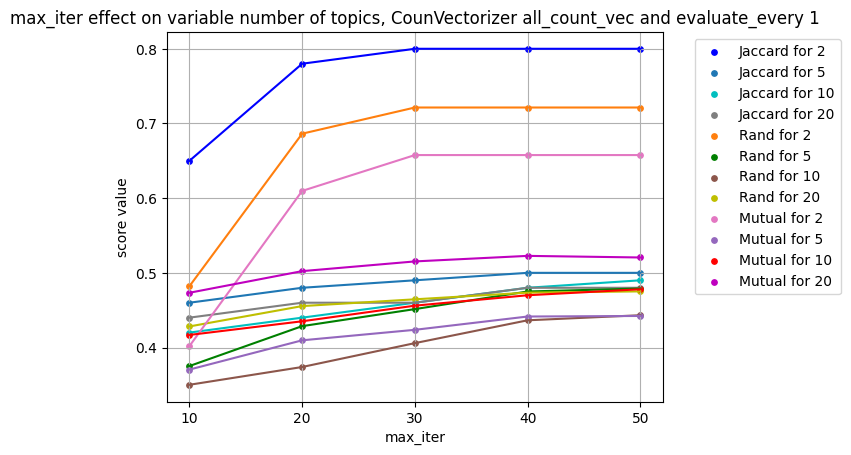

In [20]:
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
fig = plt.figure()
ax1 = fig.add_subplot(111)
j = 0
for i in num_of_topics_max_iter:
    ax1.scatter(x=max_iter_options, y=[x[0] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j], marker="o", label='Jaccard for '+str(i))
    ax1.plot(max_iter_options, [x[0] for x in list(dicts_max_iter[i].values())], c=colors[j])
    j = j +3
j = 0
for i in num_of_topics_max_iter:
    ax1.scatter(x=max_iter_options, y=[x[1] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j+1], marker="o", label='Rand for '+str(i))
    ax1.plot(max_iter_options, [x[1] for x in list(dicts_max_iter[i].values())], c=colors[j+1])
    j = j +3
j = 0
for i in num_of_topics_max_iter:
    ax1.scatter(x=max_iter_options, y=[x[2] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j+2], marker="o", label='Mutual for '+str(i))
    ax1.plot(max_iter_options, [x[2] for x in list(dicts_max_iter[i].values())], c=colors[j+2])
    j = j +3

plt.xlabel("max_iter")
plt.xticks(max_iter_options)
plt.ylabel("score value")
plt.title("max_iter effect on variable number of topics, CounVectorizer all_count_vec and evaluate_every 1")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### CountVectorizer effect

In [21]:
num_of_topics_cv = [2, 5, 10, 20]

In [18]:
dicts_cv = {}
num_of_runs_vec = 5
for t in num_of_topics_cv:
    print(t)
    dicts_cv[t] = []
    for cv in cv_options:
        iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs_vec, num_of_topics=t, max_iter_options=[40], cv=cv, random_states=random_states)
        dicts_cv[t].append(iter_metrics_dict)

2
5
10
20


In [19]:
with lzma.open("dicts_cv.txt", "wb") as model_file:
    pickle.dump(dicts_cv, model_file)

In [22]:
with lzma.open("dicts_cv.txt", "rb") as model_file:
    dicts_cv = pickle.load(model_file)

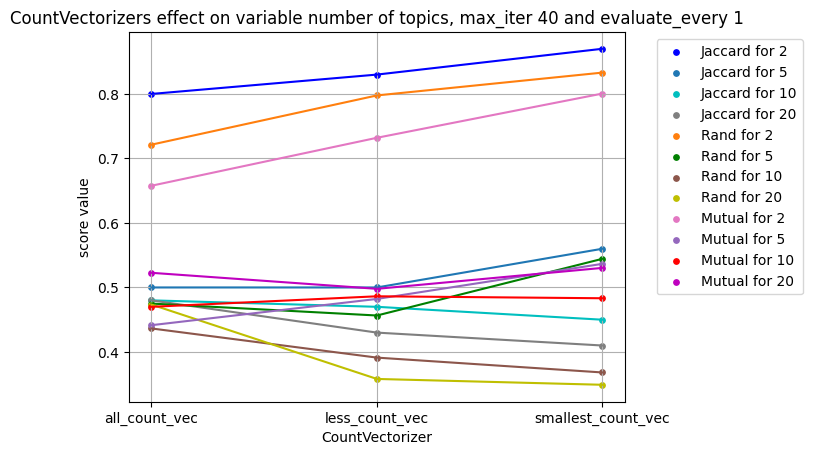

In [23]:
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
fig = plt.figure()
ax1 = fig.add_subplot(111)
j = 0
for i in num_of_topics_cv:
    ax1.scatter(x=cv_opt_string, y=[x[40][0] for x in dicts_cv[i]], s=15, c=colors[j], marker="o", label='Jaccard for '+str(i))
    ax1.plot(cv_opt_string, [x[40][0] for x in dicts_cv[i]], c=colors[j])
    j = j +3

j = 0
for i in num_of_topics_cv:
    ax1.scatter(x=cv_opt_string, y=[x[40][1] for x in dicts_cv[i]], s=15, c=colors[j+1], marker="o", label='Rand for '+str(i))
    ax1.plot(cv_opt_string, [x[40][1] for x in dicts_cv[i]], c=colors[j+1])
    j = j +3
j = 0
for i in num_of_topics_cv:
    ax1.scatter(x=cv_opt_string, y=[x[40][2] for x in dicts_cv[i]], s=15, c=colors[j+2], marker="o", label='Mutual for '+str(i))
    ax1.plot(cv_opt_string, [x[40][2] for x in dicts_cv[i]], c=colors[j+2])
    j = j +3

plt.xlabel("CountVectorizer")
plt.xticks(cv_opt_string)
plt.ylabel("score value")
plt.title("CountVectorizers effect on variable number of topics, max_iter 40 and evaluate_every 1")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Topic number options on "best setting" - stability eval
evaluate_every = 1  
max_iter = 40  
CountVectorizer -> smallest_count_vec  
number of runs = 20 

In [24]:
num_of_topics_t = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 20]

In [22]:
dict_topic = {}
num_of_runs_t = 20
for t in num_of_topics_t:
    print("topic", t)
    iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs_t, num_of_topics=t, max_iter_options=[40], cv=less_count_vec, random_states=random_states)
    dict_topic[t] = iter_metrics_dict

topic 2
topic 3
topic 4
topic 5
topic 6
topic 7
topic 8
topic 9
topic 10
topic 12
topic 15
topic 17
topic 20


In [23]:
with lzma.open("all_top_20.txt", "wb") as model_file:
    pickle.dump(dict_topic, model_file)

In [25]:
with lzma.open("all_top_20.txt", "rb") as model_file:
    dict_topic = pickle.load(model_file)

In [24]:
for t in dict_topic.keys():
    print("Number of topics:", t)
    print("  max_iter =", 40)
    print("  CountVectorizer:", "less_count_vec")
    #print("\t Jaccard index:", dict_topic[t][40][0])
    print("\t Rand index:", dict_topic[t][40][1])
    print("\t Mutual info score:", dict_topic[t][40][2])
    print()

Number of topics: 2
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.7760454283962619
	 Mutual info score: 0.711499897861247

Number of topics: 3
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.5774662064918115
	 Mutual info score: 0.5561815200453931

Number of topics: 4
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.4984284558539136
	 Mutual info score: 0.490266469629091

Number of topics: 5
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.45890875926077057
	 Mutual info score: 0.4784115917175134

Number of topics: 6
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.4958104132081498
	 Mutual info score: 0.5241400747975611

Number of topics: 7
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.44884632304775396
	 Mutual info score: 0.5020813742523358

Number of topics: 8
  max_iter = 40
  CountVectorizer: less_count_vec
	 Rand index: 0.43689375452317347
	 Mutual info score: 0.501278470

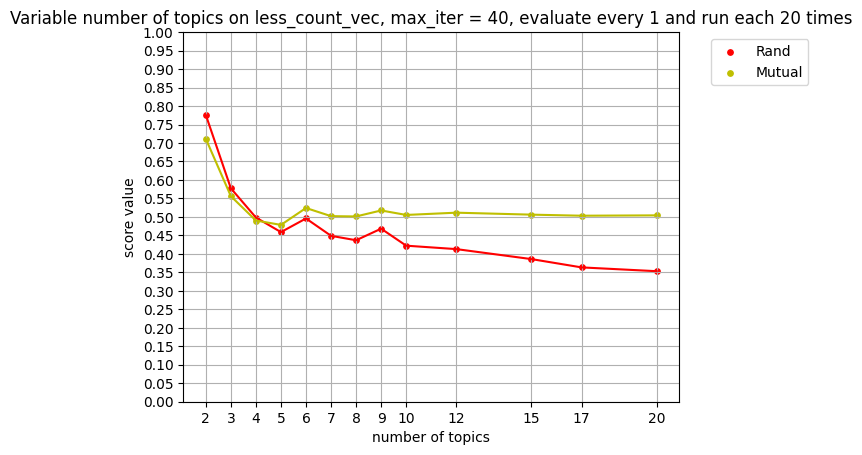

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(x=num_of_topics_t, y=[x[40][0] for x in list(dict_topic.values())], s=15, c='b', marker="o", label='Jaccard')
#ax1.plot(num_of_topics_t, [x[40][0] for x in list(dict_topic.values())], c='b')

ax1.scatter(x=num_of_topics_t, y=[x[40][1] for x in list(dict_topic.values())], s=15, c='r', marker="o", label='Rand')
ax1.plot(num_of_topics_t, [x[40][1] for x in list(dict_topic.values())], c='r')

ax1.scatter(x=num_of_topics_t, y=[x[40][2] for x in list(dict_topic.values())], s=15, c='y', marker="o", label='Mutual')
ax1.plot(num_of_topics_t, [x[40][2] for x in list(dict_topic.values())], c='y')

plt.xlabel("number of topics")
plt.xticks(num_of_topics_t)
plt.ylabel("score value")
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics on less_count_vec, max_iter = 40, evaluate every 1 and run each 20 times")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Czech sources for possible evaluation

In [26]:
six_czech_sources = {"http://cantusbohemiae.cz/source/33177" : "CZ-Pn XII A 24", 
                      "http://cantusbohemiae.cz/source/4478" : "CZ-Pu Pu XIV A 19", 
                      "http://cantusbohemiae.cz/source/28509" : "CZ-Pn XV A 10",
                      "http://cantusdatabase.org/source/123730" : "CZ-Pu XIV B 13", 
                      "http://cantusdatabase.org/source/123727" : "CZ-Pu VI.E.4c", 
                      "http://cantusbohemiae.cz/source/28488" : "CZ-Pu VI G 11"}

In [34]:
cathedral_used_feats = []
for sI in list(six_czech_sources.keys())[:3]:
    print(sI, len(chants[chants['source_id'] == sI]))
    cathedral_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

# Cathedral field
freqC = Counter(cathedral_used_feats)
three_cathedral_feasts = []
for key in freqC.keys():
    if freqC[key] >=3:
        three_cathedral_feasts.append(key)

# George monastery
monastery_used_feats = []
for sI in list(six_czech_sources.keys())[3:]:
    print(sI, len(chants[chants['source_id'] == sI]))
    monastery_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

freqM = Counter(monastery_used_feats)
three_monastery_feasts = []
for key in freqM.keys():
    if freqM[key] >= 3:
        three_monastery_feasts.append(key)

complete_feasts = set(three_cathedral_feasts).intersection(set(three_monastery_feasts))
print("Number of feast in all six sources:", len(complete_feasts))

http://cantusbohemiae.cz/source/33177 582
http://cantusbohemiae.cz/source/4478 988
http://cantusbohemiae.cz/source/28509 1741
http://cantusdatabase.org/source/123730 1403
http://cantusdatabase.org/source/123727 2327
http://cantusbohemiae.cz/source/28488 2616
Number of feast in all six sources: 37


In [35]:
# Complete data
feast_source_chants_dict = {}
feast_used_cantus_ids = []
feast_used_sources = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants[chants['source_id'] == source_id]
    source_feast_chants = (filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist()
    if source_feast_chants != []:
        feast_used_cantus_ids += source_feast_chants 
        feast_source_chants_dict[source_id] = ' '.join(source_feast_chants)
        feast_used_sources.append(source_id)

print("Used sources:", len(feast_used_sources))
print('Number of CIDs used in our sources:', len(set(feast_used_cantus_ids)))

Used sources: 153
Number of CIDs used in our sources: 1224


In [22]:
# For two to thirty topics try to find where czech sources split and how
# using all_count_vec
czech_topics = [i for i in range(2, 31)]
all_data_trans = all_count_vec.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
feast_trans_data = all_count_vec.transform(feast_source_chants_dict.values())
feast_communities = {}
for top in czech_topics:
    print(top)
    CZmodel = LatentDirichletAllocation(n_components=top, evaluate_every=1, max_iter=50, random_state=436)
    CZmodel.fit(all_data_trans)
    result = CZmodel.transform(feast_trans_data)
    topics = result.argmax(axis=1)

    restored_comm = {}
    for topic in range(top):
        restored_comm[topic] = []

    for n in range(len(topics)):
        restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

    feast_communities[top] = (restored_comm.values())

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [23]:
h = 2
czech_dict = {}
for restored_comm in feast_communities.values():
    print(h)
    for com in list(restored_comm):
        print(com)
        print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))
    h += 1
    print()

2
['http://cantusdatabase.org/source/123595', 'http://cantusdatabase.org/source/123606', 'http://cantusdatabase.org/source/123750', 'http://cantusdatabase.org/source/123718', 'http://cantusdatabase.org/source/123688', 'http://cantusdatabase.org/source/123607', 'http://cantusdatabase.org/source/123608', 'http://cantusdatabase.org/source/123672', 'http://cantusdatabase.org/source/123623', 'http://cantusdatabase.org/source/123673', 'http://cantusdatabase.org/source/123683', 'http://cantusdatabase.org/source/123684', 'http://cantusdatabase.org/source/123716', 'http://cantusdatabase.org/source/123651', 'http://cantusdatabase.org/source/123638', 'http://cantusdatabase.org/source/123639', 'http://cantusdatabase.org/source/123627', 'http://cantusdatabase.org/source/123630', 'http://cantusdatabase.org/source/123642', 'http://cantusdatabase.org/source/123592', 'http://cantusdatabase.org/source/123603', 'http://cantusdatabase.org/source/123647', 'http://cantusdatabase.org/source/123646', 'http://

### Big feasts

In [30]:
# Get 10 feasts with most data
biggest_feasts = chants['feast_id'].value_counts()[:10].keys()

for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])

Nativitas Domini
Purificatio Mariae
Epiphania
Assumptio Mariae
Comm. Apostolorum
Comm. plurimorum Martyrum
Omnium Sanctorum
Fer. 5 in Cena Dom.
Dom. in Palmis
Joannis Baptistae


In [31]:
# Construct documents structure for those feasts
source_chants_dict_big_f = {}
used_cantus_ids_f = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants['source_id'] == source_id
    source_chants = chants[filt_source]
    if (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist() != []:
        used_cantus_ids_f += (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist()
        source_chants_dict_big_f[source_id] = ' '.join(source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id'].tolist())

print('Number of cantus_ids used in our sources:', len(set(used_cantus_ids_f)))
print('Number of sources containing our biggest feasts:', len(source_chants_dict_big_f))

Number of cantus_ids used in our sources: 1701
Number of sources containing our biggest feasts: 226


In [ ]:
# Run in repeat and store "communities"
count_vec_big_f = CountVectorizer(max_df=1.0, min_df=0.0)
trans_data_big_f = count_vec_big_f.fit_transform(source_chants_dict_big_f.values())
print(trans_data_big_f.shape)
topic_metric_dict_big_f = {}

big_f_topics = [2, 3, 4, 5, 7, 10, 15, 20]
num_of_runs_big_f = 20
for t in big_f_topics:
    print(t)
    community_variants = []
    community_variants_labels = []
    for i in range(num_of_runs_big_f):
        model = LatentDirichletAllocation(n_components=t, max_iter=40, evaluate_every=1, random_state=random_states[i])
        result = model.fit_transform(trans_data_big_f)
        topics = result.argmax(axis=1)

        community_variants_labels.append(topics)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(list(source_chants_dict_big_f.keys())[n])

        community_variants.append(restored_comm.values())

    topic_metric_dict_big_f[t] = (count_jaccard(community_variants, num_of_runs_big_f), count_rand(community_variants_labels), count_mutual(community_variants_labels) )

In [26]:
print(topic_metric_dict_big_f)

{2: (0.94, 0.9488676264158153, 0.9092362819622503), 5: (0.41, 0.3911375829770148, 0.4151329006694407), 10: (0.36, 0.4128586798236591, 0.463469865231663), 20: (0.3, 0.38804296694150997, 0.48023624020209993)}


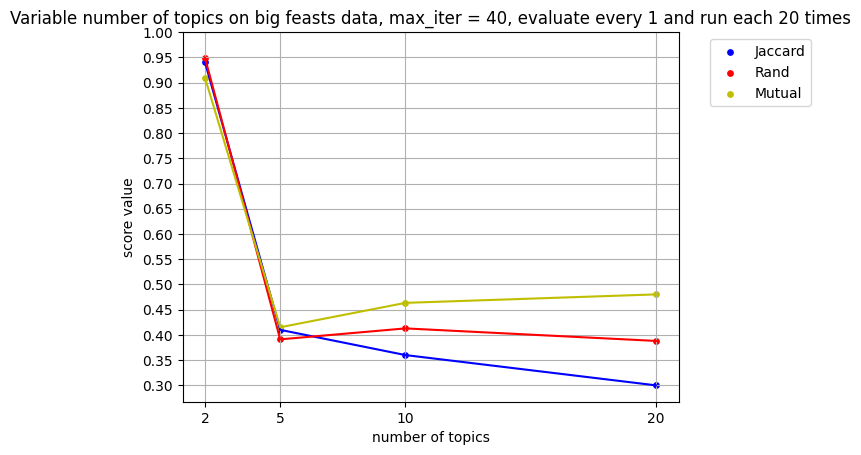

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=big_f_topics, y=[x[0] for x in list(topic_metric_dict_big_f.values())], s=15, c='b', marker="o", label='Jaccard')
ax1.plot(big_f_topics, [x[0] for x in list(topic_metric_dict_big_f.values())], c='b')

ax1.scatter(x=big_f_topics, y=[x[1] for x in list(topic_metric_dict_big_f.values())], s=15, c='r', marker="o", label='Rand')
ax1.plot(big_f_topics, [x[1] for x in list(topic_metric_dict_big_f.values())], c='r')

ax1.scatter(x=big_f_topics, y=[x[2] for x in list(topic_metric_dict_big_f.values())], s=15, c='y', marker="o", label='Mutual')
ax1.plot(big_f_topics, [x[2] for x in list(topic_metric_dict_big_f.values())], c='y')

plt.xlabel("number of topics")
plt.xticks(big_f_topics)
plt.ylabel("score value")
plt.yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics on big feasts data, max_iter = 40, evaluate every 1 and run each 20 times")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Two topics and cursus?
Try to build two topic models (on different CV) and examine if their split is possible based on cursus? (I would not guess any sicces, especially bc many unknown in data...)

In [39]:
num_of_runs_cursus = 20
cursus_dict = {}
j = 0
for cv in cv_options:
    cursus_dict[cv_opt_string[j]] = {}
    community_variants = []
    for i in range(num_of_runs_cursus):
        model = LatentDirichletAllocation(n_components=2, max_iter=30, evaluate_every=1, random_state=random_states[i])
        result = model.fit_transform(trans_data_big_f)
        topics = result.argmax(axis=1)

        restored_comm = {}
        for topic in range(t):
            restored_comm[topic] = []

        for n in range(len(topics)):
            restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])
        for com in restored_comm.values():
            cursus_dict[cv_opt_string[j]][i] = Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in com])
            print(Counter([sources[sources['drupal_path'] == s_id]['cursus'].values[0] for s_id in com]))
        print()
    j += 1


Counter({'Secular': 51, 'Unknown': 38, 'Monastic': 16, 'Romanum': 2})
Counter({'Secular': 57, 'Monastic': 33, 'Unknown': 28, 'Romanum': 1})

Counter({'Secular': 58, 'Monastic': 34, 'Unknown': 28, 'Romanum': 1})
Counter({'Secular': 50, 'Unknown': 38, 'Monastic': 15, 'Romanum': 2})

Counter({'Secular': 59, 'Monastic': 33, 'Unknown': 28, 'Romanum': 1})
Counter({'Secular': 49, 'Unknown': 38, 'Monastic': 16, 'Romanum': 2})

Counter({'Secular': 50, 'Unknown': 39, 'Monastic': 16, 'Romanum': 2})
Counter({'Secular': 58, 'Monastic': 33, 'Unknown': 27, 'Romanum': 1})

Counter({'Secular': 58, 'Monastic': 34, 'Unknown': 29, 'Romanum': 1})
Counter({'Secular': 50, 'Unknown': 37, 'Monastic': 15, 'Romanum': 2})

Counter({'Secular': 51, 'Unknown': 39, 'Monastic': 16, 'Romanum': 2})
Counter({'Secular': 57, 'Monastic': 33, 'Unknown': 27, 'Romanum': 1})

Counter({'Secular': 50, 'Unknown': 37, 'Monastic': 15, 'Romanum': 2})
Counter({'Secular': 58, 'Monastic': 34, 'Unknown': 29, 'Romanum': 1})

Counter({'Sec

### Provenance union

In [48]:
def count_dict_jaccard(vars, num_of_runs, spec_dict):
    friends_matrix = np.zeros([len(spec_dict), len(spec_dict)])
    for com_ver in vars:
        for com in com_ver:
            com = sorted(list(com))
            for pair in combinations(com, 2):
                friends_matrix[spec_dict[pair[0]], spec_dict[pair[1]]] += 1

    sig_level = round((np.sum(friends_matrix) / np.count_nonzero(friends_matrix)) / num_of_runs, 2)
    return sig_level

In [42]:
# Provenance union - consider also century and cursus
sources['provenance_id'] = sources['provenance_id'].fillna('unknown')
prov_source_dict = {}
prov_chant_dict = {}
i=0
for index, row in sources.iterrows():
        # new place bc of unknown some info
    if row['cursus'] == 'Unknown' or row['num_century'] == 'unknown' or row['provenance_id'] == 'unknown':
        prov_source_dict[row['provenance_id']+'_'+str(i)] = [row['drupal_path']]
        i+=1
    # we have such place without unknown positions
    elif row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus'] in prov_source_dict.keys():
        prov_source_dict[row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus']].append(row['drupal_path'])
    # new time-cursus-place without unknown positions
    else: 
        prov_source_dict[row['provenance_id']+'_'+row['num_century']+'_'+row['cursus']] = [row['drupal_path']]

for prov in prov_source_dict.keys():
    prov_chant_dict[prov] = ''
    for source_id in prov_source_dict[prov]:
        filt_source = chants['source_id'] == source_id
        prov_chant_dict[prov] += ' '.join(chants[filt_source]['cantus_id'])

print('number of reduced source points:',  len(prov_chant_dict), '(out of', len(sources), 'sources)')

number of reduced source points: 193 (out of 250 sources)


In [62]:
prov_cv = CountVectorizer(min_df=15, max_df=len(prov_chant_dict))
prov_cv_data = prov_cv.fit_transform(prov_chant_dict.values())
print("[sources x chants] matrix shape:", prov_cv_data.shape)

[sources x chants] matrix shape: (193, 3827)


In [44]:
used_provenances = list(prov_chant_dict.keys())
provenance_dict = OrderedDict()
i = 0
for id in used_provenances:
    provenance_dict[id] = i
    i += 1

In [58]:
def LDA_prov_run(num_of_runs, num_of_topics, max_iter_options, random_states, prov_dict):
    iter_metric_dict = {}
    for iter in max_iter_options:
        print(iter)
        community_variants = []
        community_variants_labels = []
        for i in range(num_of_runs):
            model = LatentDirichletAllocation(n_components=num_of_topics, max_iter=iter, evaluate_every=1, random_state=random_states[i])
            data_trans = prov_cv.fit_transform([data for data in prov_chant_dict.values()])
            result = model.fit_transform(data_trans)
            topics = result.argmax(axis=1)

            community_variants_labels.append(topics)

            restored_comm = {}
            for topic in range(num_of_topics):
                restored_comm[topic] = []

            for n in range(len(topics)):
                restored_comm[topics[n]].append(list(prov_dict.keys())[n])

            community_variants.append(restored_comm.values())

        iter_metric_dict[iter] = (count_dict_jaccard(community_variants, num_of_runs, prov_dict), count_rand(community_variants_labels), count_mutual(community_variants_labels) )

    return iter_metric_dict

In [65]:
dict_prov_topic = {}
num_of_runs_prov = 10
num_of_topics_prov = [2, 3, 4, 5] # 7, 10, 15, 20]
for t in num_of_topics_prov:
    print("topic", t)
    iter_metrics_dict = LDA_prov_run(num_of_runs=num_of_runs_prov, num_of_topics=t, 
                                     max_iter_options=[40], random_states=random_states, 
                                     prov_dict=provenance_dict)
    dict_prov_topic[t] = iter_metrics_dict

topic 2
40
topic 3
40
topic 4
40
topic 5
40


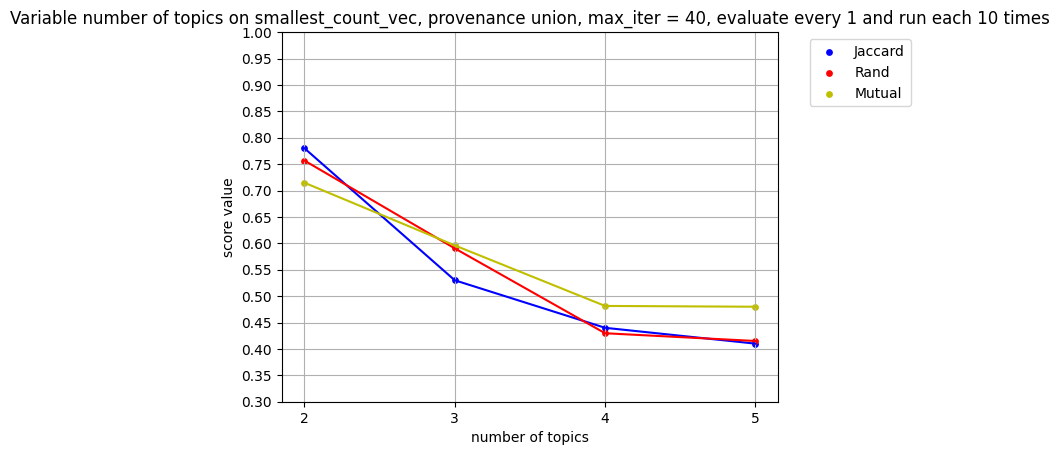

In [66]:
# Plot it
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=num_of_topics_prov, y=[x[40][0] for x in list(dict_prov_topic.values())], s=15, c='b', marker="o", label='Jaccard')
ax1.plot(num_of_topics_prov, [x[40][0] for x in list(dict_prov_topic.values())], c='b')

ax1.scatter(x=num_of_topics_prov, y=[x[40][1] for x in list(dict_prov_topic.values())], s=15, c='r', marker="o", label='Rand')
ax1.plot(num_of_topics_prov, [x[40][1] for x in list(dict_prov_topic.values())], c='r')

ax1.scatter(x=num_of_topics_prov, y=[x[40][2] for x in list(dict_prov_topic.values())], s=15, c='y', marker="o", label='Mutual')
ax1.plot(num_of_topics_prov, [x[40][2] for x in list(dict_prov_topic.values())], c='y')

plt.xlabel("number of topics")
plt.xticks(num_of_topics_prov)
plt.ylabel("score value")
plt.yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics on smallest_count_vec, provenance union, max_iter = 40, evaluate every 1 and run each 10 times")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()